In [41]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [42]:
# I got error on downloading this dataset so I only use it online without downloading

#transform data into Tensor and normalize with mean = 0.5, standard deviation = 0.5 -> do lech chuan
transform = transforms.Compose([
    transforms.ToTensor() ,
    transforms.Normalize((0.5, 0.5 , 0.5),(0.5, 0.5 , 0.5))
])


training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform= transform
)

test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform= transform
)

#after transform image become tensor and can only displayed using plt.imshow with img.squeeze()

Files already downloaded and verified
Files already downloaded and verified


In [43]:
from torch.utils.data import DataLoader


epoch_num = 3
batch_size_train = 64
batch_size_test = 1000
l_r = 0.01
momentum = 0.9
log_interval = 100  #how often the training result being printed (1 time for every 100 batches)

random_seed = 10
# torch.manual_seed(random_seed)


In [44]:
# for shuffling the dataset when we sample a minibatch in the training phase 

train_dataloader = DataLoader(training_data , batch_size = batch_size_train , shuffle= True)
test_dataloader = DataLoader(test_data , batch_size= batch_size_test, shuffle = False )


In [45]:
import numpy as np 

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.099999994..0.9].


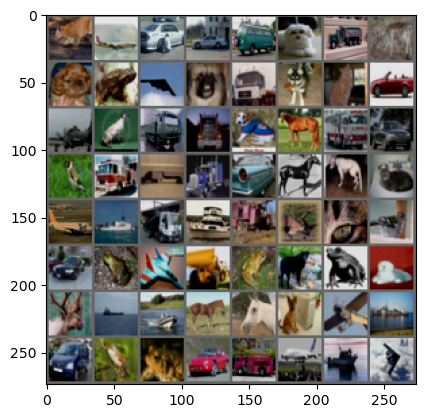

In [47]:
# to see a batch when DataLoader sampling, using next(iter(...)) #a batch is 64 figures size 1x28x28 and it's labels
train_features, train_labels = next(iter(train_dataloader))


#imshow redefinited function to display image using plt.imshow
def imshow(img):
    img = img/2 + 0.4
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

imshow(torchvision.utils.make_grid(train_features))


In [48]:
def train_model(model , criterion , optimizer , scheduler, epoch_num = 20):
    since = time.time()
    model.train()
    for epoch in range(epoch_num):
        print(f'Epoch {epoch}/{epoch_num - 1}')
        print('-' * 10)

        running_loss = 0.0 
        for inputs , labels in train_dataloader:
            # inputs, labels = inputs.to(device) , labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
        print(f'Epoch [{epoch + 1}/{epoch_num}], Loss: {running_loss / len(train_dataloader)}')

    print('Finished Training')



In [49]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
model = models.resnet101(weights= 'ResNet101_Weights.IMAGENET1K_V2')
num_ftrs = model.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(num_ftrs, len(classes))
# model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [50]:
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model = train_model(model = model, criterion = criterion  , optimizer = optimizer,scheduler= exp_lr_scheduler , epoch_num= 25)

Epoch 0/24
----------
Epoch [1/25], Loss: 2.2759392474923295
Epoch 1/24
----------
Epoch [2/25], Loss: 2.2722801524964744
Epoch 2/24
----------
Epoch [3/25], Loss: 2.27371399481888
Epoch 3/24
----------


KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() #use evaluation mode in order to stop using drop out
correct = 0
total = 0
with torch.no_grad(): #disable gradient calculating to saving memory
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device) #send to device to use cpu or gpu 
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) #Gets the predicted class by finding the index of the maximum value in the output tensor along dimension 1
        total += labels.size(0)
        for i in predicted:
            if predicted[i] == labels[i]:
                correct+=1
        
print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')